# Immigration Vs GDP

This analysis merges data from OECD and the UN for GDP, population and in migration rates. GDP values are per-capital GDP, in constant US dollars, at PPP for 2010 


In [1]:
import metatab
import pandas as pd

import matplotlib.pyplot
%matplotlib notebook
matplotlib.style.use('ggplot')

doc = metatab.open_package('..') # Assumes you started Jupyter in the same dir as the metadata file

# To run this on the web, without downloading the data package
#package_url='https://raw.githubusercontent.com/CivicKnowledge/metatab-packages/master/civicknowledge.com/immigration-vs-gdp/metadata.csv'
#doc = metatab.open_package(package_url)

list(r.name for r in doc.resources())

pop_df = doc.first_resource('total_pop').dataframe()
gdp_df = doc.first_resource('country_gdp').dataframe()
md_df = doc.first_resource('migration').dataframe()


In [2]:
# Add a year-over-year GDP change to the GDP file. 
gdpm=gdp_df[ (gdp_df.subject_code == 'T_GDPPOP') & ( gdp_df.measure_code=='CPC')][[ 'location','time','gdp']]
gdpm['time'] = pd.to_datetime(gdpm.time, format='%Y') # Turn year integers into datetime64 values
gdpm.set_index(['location','time'], inplace=True)
gdpm['change'] = gdpm.pct_change(periods=1)
gdpm.reset_index( inplace=True)
gdpm.to_csv('../data/gdp-pop-migration.csv') # Save file for debugging. 

In [3]:
# CPC == USD, current prices, current PPPs
# T_GDP == Gross Domestic Product (GDP); millions
# B11 == Inflows of foreign population by nationality
# TOT == total in migration into a country

# GDP For 2014
gdp2014=gdpm[gdpm.time.dt.year == 2014]
# 2014 total inmigration per country
md2014 = md_df[ (md_df.year==2014) & (md_df['var'] == 'B11') & (md_df.country_code == 'TOT')] 
# Middle variant estimated population per country for 2014. 
pop2014 = pop_df[(pop_df.variant == 'Medium') & ( pop_df.time == 2014)]

In [4]:
#Create an index of all of the country names and codes, to use as a "backbone" for merging. 
l1 = md2014[['country','cou']].drop_duplicates()
l2 = pop2014[['location','locid']].drop_duplicates()

index = l2.merge(l1, how='outer', left_on='location', right_on='country')
index.loc[index.location=='United States of America',['country','cou']] = ['United States', 'USA']
index.to_csv('/tmp/countries.csv')


In [12]:
gpop = index\
.merge(gdp2014, left_on='cou', right_on='location', suffixes=('','_gdp'))\
.merge(pop2014, on='locid', suffixes=('','_pop'))\
.merge(md2014, on='cou', suffixes=('','_md')) \
.set_index('cou')\
['location gdp change poptotal growthrate popdensity in_migration_count'.split()].copy()

In [13]:
# Adjust for population
gpop['migrant_per_pop'] = gpop.in_migration_count / gpop.poptotal

# Average GSDP change rate
gdp_a = gdpm.groupby('location').mean()[['change']]
# Average Annual migration
md_a = md_df[(md_df['var'] == 'B11') & (md_df.country_code == 'TOT')].groupby('cou').mean()[['in_migration_count']]

# Change some column names
md_a.columns  = ['in_migration_avg']
gdp_a.columns = ['gdp_change_avg']

# Merge the averages back in
gpop_a = gpop.merge(gdp_a, left_index=True, right_index=True).merge(md_a, left_index=True, right_index=True)


<IPython.core.display.Javascript object>


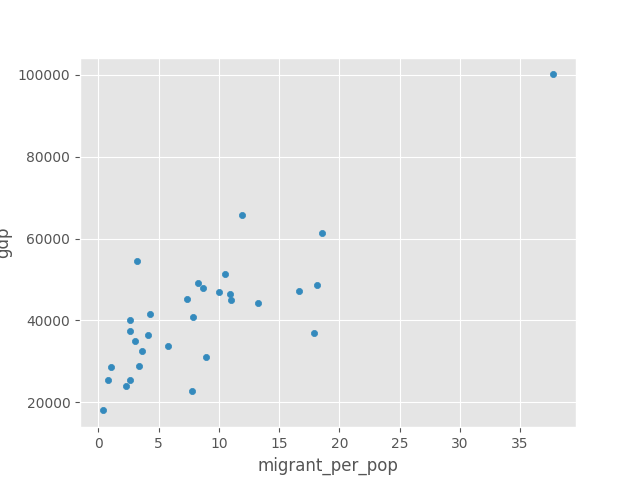

In [14]:
gpop.plot.scatter(x='migrant_per_pop',y='gdp')

In [8]:
gpop.corr()

,gdp,change,poptotal,growthrate,popdensity,in_migration_count,migrant_per_pop
gdp,1.000000,-0.141087,-0.013869,0.544257,0.151443,0.146481,0.812154
change,-0.141087,1.000000,-0.000409,-0.315530,-0.046626,-0.002868,0.041637
poptotal,-0.013869,-0.000409,1.000000,0.035358,0.016351,0.675689,-0.275190
growthrate,0.544257,-0.315530,0.035358,1.000000,0.008752,-0.026165,0.492845
popdensity,0.151443,-0.046626,0.016351,0.008752,1.000000,0.140493,0.074832
in_migration_count,0.146481,-0.002868,0.675689,-0.026165,0.140493,1.000000,0.058945
migrant_per_pop,0.812154,0.041637,-0.275190,0.492845,0.074832,0.058945,1.000000


In [9]:
#gdp2014=gdpm[gdpm.time.dt.year == 2014]
#md2014 = md_df[ (md_df.year==2014) & (md_df['var'] == 'B11') & (md_df.country_code == 'TOT')] # 'Inflows of foreign population by nationality'
#pop2014 = pop_df[(pop_df.variant == 'Medium') & ( pop_df.time == 2014)]

In [10]:
gpop_a.corr()

,gdp,change,poptotal,growthrate,popdensity,in_migration_count,migrant_per_pop,gdp_change_avg,in_migration_avg
gdp,1.000000,-0.141087,-0.013869,0.544257,0.151443,0.146481,0.812154,0.365148,0.131238
change,-0.141087,1.000000,-0.000409,-0.315530,-0.046626,-0.002868,0.041637,-0.233636,-0.026512
poptotal,-0.013869,-0.000409,1.000000,0.035358,0.016351,0.675689,-0.275190,-0.097599,0.811843
growthrate,0.544257,-0.315530,0.035358,1.000000,0.008752,-0.026165,0.492845,0.221809,-0.061768
popdensity,0.151443,-0.046626,0.016351,0.008752,1.000000,0.140493,0.074832,-0.118859,0.091313
in_migration_count,0.146481,-0.002868,0.675689,-0.026165,0.140493,1.000000,0.058945,-0.000246,0.923056
migrant_per_pop,0.812154,0.041637,-0.275190,0.492845,0.074832,0.058945,1.000000,0.257201,-0.055058
gdp_change_avg,0.365148,-0.233636,-0.097599,0.221809,-0.118859,-0.000246,0.257201,1.000000,-0.021490
in_migration_avg,0.131238,-0.026512,0.811843,-0.061768,0.091313,0.923056,-0.055058,-0.021490,1.000000


<IPython.core.display.Javascript object>


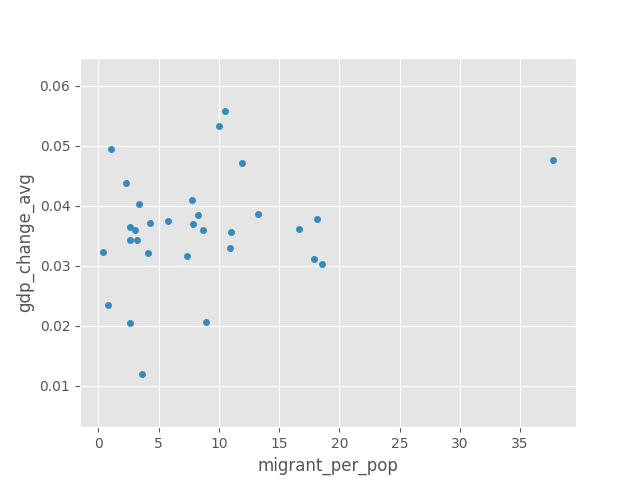

In [11]:
gpop_a.plot.scatter(x='migrant_per_pop',y='gdp_change_avg')